##Google Colab Stuff

In [3]:
import os
os.chdir('/content')

from google.colab import files

uploaded = files.upload()

!ls

Saving ssh.tar.gz to ssh.tar.gz
sample_data  ssh.tar.gz


In [4]:
#Remove the .ssh Folder if it already exists
!rm -rf /root/.ssh

#Create a new .ssh folder
!mkdir /root/.ssh

#Unzip the archive file
!tar xzvf ssh.tar.gz

#Copy the files to /root/.ssh
!cp ssh-colab/* /root/.ssh && rm -rf ssh-colab && rm -rf ssh.tar.gz
!chmod 700 /root/.ssh

#Add the git server as a ssh known host
!touch /root/.ssh/known_hosts
!ssh-keyscan github.com >> /root/.ssh/known_hosts
!chmod 644 /root/.ssh/known_hosts

ssh-colab/
ssh-colab/id_rsa_colab
ssh-colab/config
ssh-colab/id_rsa_colab.pub
# github.com:22 SSH-2.0-babeld-6c2374e6
# github.com:22 SSH-2.0-babeld-6c2374e6
# github.com:22 SSH-2.0-babeld-6c2374e6


In [5]:
#Run the agent, then run `ssh-add /root/.ssh/id_rsa_colab` in the prompt, optionally followed by `ssh-add -l` to verify, finally type `exit`
!ssh-agent /bin/bash

bash: cannot set terminal process group (125): Inappropriate ioctl for device
bash: no job control in this shell
]0;root@45e18bfd0981: /contentroot@45e18bfd0981:/content# ssh-add /root/.ssh/id_rsa_colab
Identity added: /root/.ssh/id_rsa_colab (pankajb64@gmail.com)
]0;root@45e18bfd0981: /contentroot@45e18bfd0981:/content# exit
exit


In [0]:
!git config --global user.email "pankajb64@gmail.com"
!git config --global user.name "pankajb64"

In [7]:
!git clone git@github.com:deepskies/stronglensbnns.git

Cloning into 'stronglensbnns'...
remote: Enumerating objects: 409, done.
remote: Counting objects: 100% (409/409), done.
remote: Compressing objects: 100% (245/245), done.
remote: Total 409 (delta 164), reused 390 (delta 145), pack-reused 0
Receiving objects: 100% (409/409), 7.00 MiB | 8.75 MiB/s, done.
Resolving deltas: 100% (164/164), done.


In [0]:
from google.colab import auth
auth.authenticate_user()

##Download dataset

In [9]:
!gsutil  -m cp  gs://strong_lens_challenge/Space_set_1/SpaceBasedChallenge.1.tar.gz stronglensbnns/data/

Copying gs://strong_lens_challenge/Space_set_1/SpaceBasedChallenge.1.tar.gz...
/ [1/1 files][  3.6 GiB/  3.6 GiB] 100% Done  69.7 MiB/s ETA 00:00:00           
Operation completed over 1 objects/3.6 GiB.                                      


In [10]:
!gsutil cp gs://strong_lens_challenge/Space_set_1/euclidB_image_catalog.csv stronglensbnns/data/

Copying gs://strong_lens_challenge/Space_set_1/euclidB_image_catalog.csv...
/ [1 files][ 11.1 MiB/ 11.1 MiB]                                                
Operation completed over 1 objects/11.1 MiB.                                     


In [11]:
!cd stronglensbnns/data && tar xf SpaceBasedChallenge.1.tar.gz && rm -rf SpaceBasedChallenge.1.tar.gz && ls

bayesiancnn	  Data_EuclidBig.3  Data_EuclidBig.7  euclidB_image_catalog.csv
Data_EuclidBig.0  Data_EuclidBig.4  Data_EuclidBig.8  README
Data_EuclidBig.1  Data_EuclidBig.5  Data_EuclidBig.9
Data_EuclidBig.2  Data_EuclidBig.6  ensai


In [12]:
!cd stronglensbnns/data && mkdir -p Space_set_1 && mv Data_* Space_set_1 && rm README && ls

bayesiancnn  ensai  euclidB_image_catalog.csv  Space_set_1


##Begin Notebook

In [0]:
#@title
from __future__ import print_function

import os
import sys
import time
import argparse
import datetime
import math
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

import torch
import torch.utils.data as data
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.autograd import Variable

from astropy.io import fits
from fastai.vision import *
#from scipy.special import softmax
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression


In [0]:
os.chdir('stronglensbnns/src/notebooks')

In [15]:
!git pull

Already up to date.


In [0]:
#add the  bayesiancnnn and ensai src to import path - https://stackoverflow.com/a/35273613/7154530
bcnn_module_path = os.path.abspath(os.path.join('../bayesiancnn'))
if bcnn_module_path not in sys.path:
    sys.path.append(bcnn_module_path)
    
ensai_module_path = os.path.abspath(os.path.join('../ensai'))
if ensai_module_path not in sys.path:
    sys.path.append(ensai_module_path)

In [0]:
from BBBlayers import GaussianVariationalInference, FlattenLayer, BBBLinearFactorial
from BayesianModels.BayesianAlexNet import BBBAlexNet
from BayesianModels.BayesianAlexNetBatchNorm import BBBAlexNetBatchNorm


In [0]:
df = pd.read_csv('../../data/euclidB_image_catalog.csv', skiprows=24)

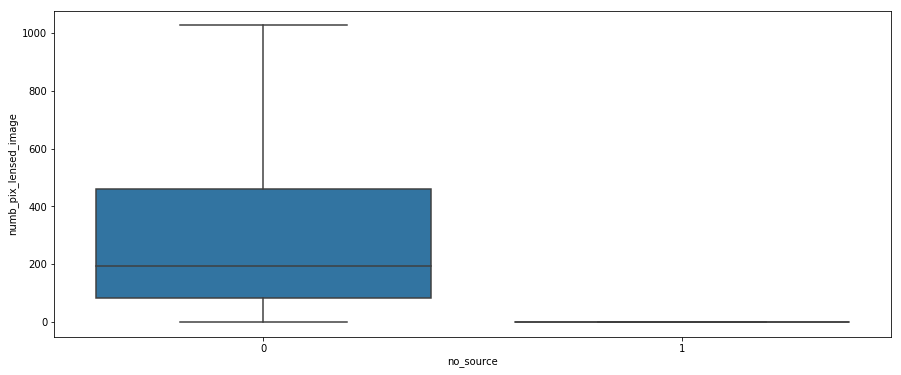

In [19]:
fig, ax = plt.subplots(figsize=(15,6))
sns.boxplot(x=df['no_source'], y=df['numb_pix_lensed_image'], showfliers=False, ax=ax)

If the instance is a source (i.e `no_source = 0`), then we can a distribution of lensed image pixels with first and third quartile being around 100 and 500. So lets use these instances for training.

In [0]:
df_lens = df.loc[(df['numb_pix_lensed_image'] > 100) & (df['numb_pix_lensed_image'] < 500)]

(0, 2e-10)

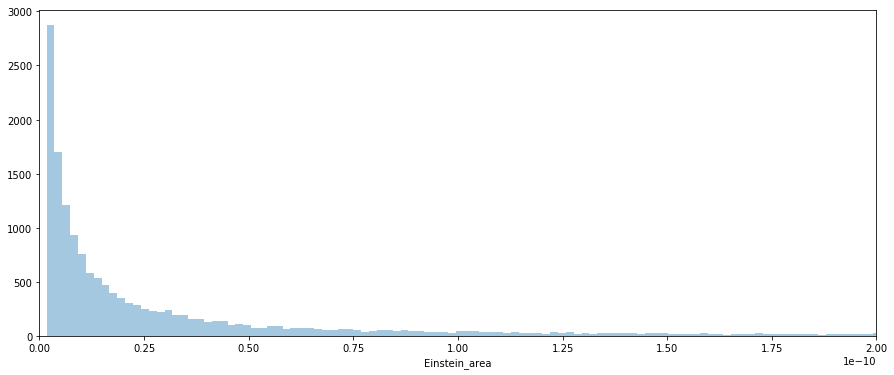

In [21]:
fig, ax = plt.subplots(figsize=(15,6))
sns.distplot(df_lens['Einstein_area'], bins=1000, ax=ax, kde=False)
ax.set_xlim(0, 0.2e-9)

It may help to scale the values to avoid running into floating point errors, and also to take the log of the distribution since the above curve is exponential. I found that scaling values by 2e10 and taking log gave a nice symmetric range for distribution

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


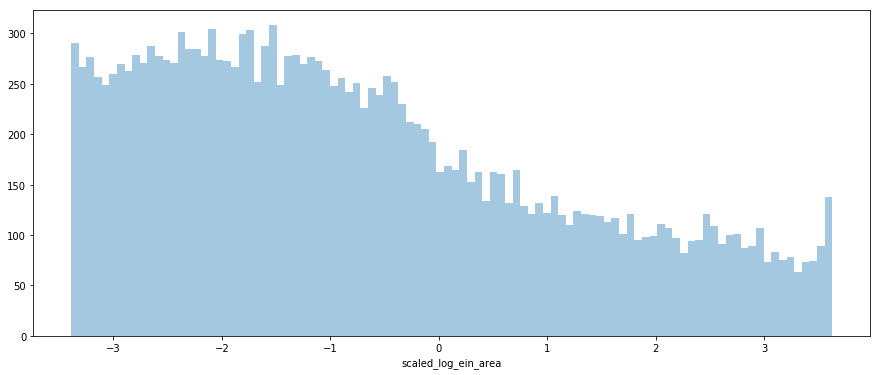

In [22]:
df_lens['scaled_log_ein_area'] = np.log(df_lens['Einstein_area']) + np.log(2e10)
fig, ax = plt.subplots(figsize=(15,6))
sns.distplot(df_lens['scaled_log_ein_area'], bins=100, ax=ax, kde=False)
#ax.set_xlim(0, 0.2)

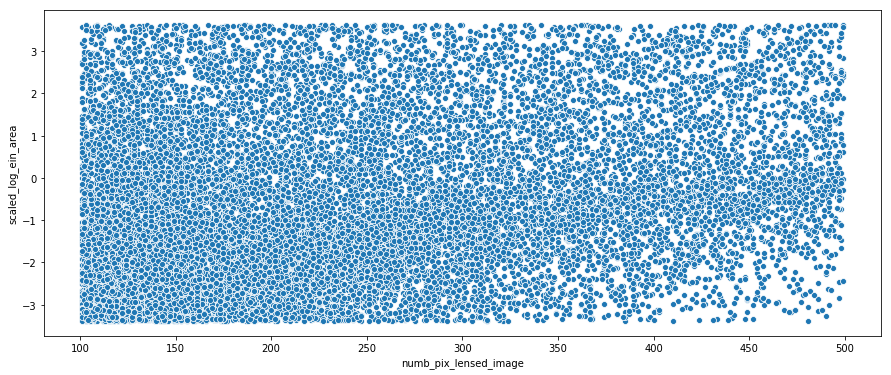

In [23]:
fig, ax = plt.subplots(figsize=(15,6))
sns.scatterplot(df_lens['numb_pix_lensed_image'], df_lens['scaled_log_ein_area'], ax=ax)

So the Einstein area and the number of lensed are uncorrelated, and were likely chosen independently in the simulation.

Convert FITS images to JPG to alow FastAI to process them.

In [0]:
dirs = ['../../data/Space_set_1/{}'.format(d) for d in os.listdir('../../data/Space_set_1/') if 'Data' in d]

In [0]:
files = []
for d in dirs:
    fits_dir = '{}/Public/Band1'.format(d)
    jpg_dir = '{}/Public_jpg/Band1'.format(d)
    os.makedirs(jpg_dir, exist_ok=True)
    for f in os.listdir(fits_dir):
        fname = fits_dir + '/' + f
        ar = fits.open(fname)[0].data
        id = int(fname.split('-')[1].split('.')[0])
        fj = '{}/{}.jpg'.format(jpg_dir, id)
        plt.imsave(fj, ar)
        files.append(fj)

In [0]:
df_files = pd.DataFrame()
df_files['fname'] = files
df_files['ID'] = [int(os.path.splitext(os.path.basename(fname))[0]) for fname in files]

In [0]:
df_merge = pd.merge(df_lens, df_files, on='ID')

In [0]:
#@title
#net_type = 'houses-bnn'
#dataset = 'houses'
net_type = 'alexnet'
dataset = 'stronglens-challenge'
numpix_side = 101
outputs = 1
inputs = 3
regression = True
resume = False
start_epoch = 0
n_epochs = 50 #set to 10 for MNIST, 30 for cifar10, and 200 for house pricing
lr = 1e-3
weight_decay = 1e-4
num_samples = 10
beta_type = "Blundell"
resize=224
optim_type = 'Adam'
best_acc = 0
best_loss = np.inf
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 16
# percentage of training set to use as validation
valid_size = 0.1
#load every nth saved epoch (change to a smaller number for classification problems where num_epochs is less)
load_multiple = 1 #set to 25 (or 10) for house pricing, 1 for MNIST, 3 for cifar10
classes = ['einsten_area']
output_names = ['Einstein Area'] #['Einstein Radius', 'Ellipticity (x)', 'Ellipticity (y)', 'Center (x)', 'Center (y)']
num_channels = 3

Create a `DataBunch` - a way to access training and validation set in FastAI. Transform it using standard image processing transforms - rotate, zoom, flip, etc. Resize the image to be 224x224 (needed for resnets)

**Normalize the image using Imagenet stats - this is important since the model is pre-trained on Imagenet.**

In [0]:
data = (ImageList
.from_df(path='', df=df_merge, cols='fname')
.split_by_rand_pct(seed=42)
.label_from_df(cols='scaled_log_ein_area',label_cls=FloatList)
.transform(get_transforms(), size=(resize,resize))
.databunch(bs=batch_size)
.normalize(imagenet_stats))

Get the Training and Test Dataset and Data Loader

In [0]:
trainset = data.train_ds
testset = data.valid_ds
trainloader = data.train_dl
testloader = data.valid_dl

In [0]:
# Hyper Parameter settings
use_cuda = torch.cuda.is_available()
if use_cuda is True:
    torch.cuda.set_device(0)

In [0]:
from fastai.vision import *
from fastai.vision.learner import num_features_model
#model = create_bnn_model(resnet18, outputs)

This class loads a pre-trained Frequentist model and adds Bayesian linear layers to it.

In [0]:
class BayesianPreTrainedModel(nn.Module):
  def __init__(self, body, outputs, freeze_base=True):
    super(BayesianPreTrainedModel, self).__init__()
    self.base_model = body
    if freeze_base:
      for param in self.base_model.parameters():
        param.requires_grad = False
    nf = num_features_model(nn.Sequential(*self.base_model.children())) * 2
    lin_ftrs = [nf, 512, outputs]
    self.pool1 = AdaptiveConcatPool2d()
    self.flatten = Flatten()
    self.linear1 = BBBLinearFactorial(nf, 512)
    self.actn1 = nn.ReLU(inplace=True)
    self.bn1 = nn.BatchNorm1d(512, momentum=0.01)
    self.linear2 = BBBLinearFactorial(512, outputs)

    self.layers = [self.base_model, self.pool1, self.flatten, self.linear1, self.actn1, self.bn1, self.linear2]

  def unfreeze(self):
      for param in self.base_model.parameters():
        param.requires_grad = True

  def freeze(self):
    for param in self.base_model.parameters():
        param.requires_grad = True

  def probforward(self, x, ret_mean_std=False):
    'Forward pass with Bayesian weights'
    kl = 0
    fc_qw_mean = 0
    fc_qw_std = 0
    
    #import pdb; pdb.set_trace()

    for layer in self.layers:
        if hasattr(layer, 'convprobforward') and callable(layer.convprobforward):
            x, _kl, = layer.convprobforward(x)
            kl += _kl

        elif hasattr(layer, 'fcprobforward') and callable(layer.fcprobforward):
            if ret_mean_std:
                x, _kl, fc_qw_mean, fc_qw_std = layer.fcprobforward(x, True)
                kl += _kl
            else:
                #print(layer)
                x, _kl = layer.fcprobforward(x, ret_mean_std=False)
                kl += _kl    
        else:
            x = layer(x)
    logits = x
    #print('logits', logits)

    if not ret_mean_std:
        return logits, kl
    else:
        return logits, kl, fc_qw_mean, fc_qw_std

Create a Bayesian Pre-Trained model using Resnet 18

In [0]:
body = create_body(models.resnet18, pretrained=True, cut=None)
net = BayesianPreTrainedModel(body, outputs)
#net = BBBAlexNetBatchNorm(outputs,inputs)
if use_cuda:
    net.cuda()

loss = torch.nn.MSELoss()
vi = GaussianVariationalInference(loss, log=True)

#summary(net, input_size=(inputs, numpix_side, numpix_side))

#logfile = os.path.join('diagnostics_Bayes{}_{}.txt'.format(net_type, dataset))

Helper functions for printing and varying parameters

In [0]:
#Pretty print estimates
def pp_estimates(names, confidence_mean, confidence_var, epistemic, aleatoric, tag='Parameter'):
    print('\n\n----------------------------------------------------------------------------------------------\n')
    print(    '|{:>15s}| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |\n'.format(tag))
    print(    '----------------------------------------------------------------------------------------------\n')
    for i in range(len(names)):
        print('|{:>15s}|{:>17.4f}|{:>10.4f}|{:>23.4f}|{:>23.4f}|\n'.format(names[i], confidence_mean[i], confidence_var[i], epistemic[i], aleatoric[i]))
    print(    '----------------------------------------------------------------------------------------------\n\n')
    

In [0]:
def learning_rate(init, epoch):
    optim_factor = 0
    if(epoch > 10):
        optim_factor = 3
    elif(epoch > 20):
        optim_factor = 2
    elif(epoch > 30):
        optim_factor = 1

    return init*math.pow(0.2, optim_factor)

def get_hms(seconds):
    m, s = divmod(seconds, 60)
    h, m = divmod(m, 60)

    return h, m, s

Functions to train and test for an epoch

In [0]:
#@title
def train(epoch, write=False):
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    m = math.ceil(len(trainset) / batch_size)
    optimizer = optim.Adam(net.parameters(), lr=learning_rate(lr, epoch), weight_decay=weight_decay)

    if write:
      print('\n=> Training Epoch #%d, LR=%.4f' %(epoch, learning_rate(lr, epoch)))
    for batch_idx, (inputs_value, targets) in enumerate(trainloader): 
        x = inputs_value.view(-1, inputs, resize, resize).repeat(num_samples, 1, 1, 1)
        #x_nobias = remove_image_intensity_bias(x)
        #x = x_nobias.repeat(1, 1, 1, 1)
        y = targets.view(-1, outputs).repeat(num_samples, 1)
        if use_cuda:
            x, y = x.cuda(), y.cuda() # GPU settings

        if beta_type is "Blundell":
            beta = 2 ** (m - (batch_idx + 1)) / (2 ** m - 1)
        elif beta_type is "Soenderby":
            beta = min(epoch / (num_epochs // 4), 1)
        elif beta_type is "Standard":
            beta = 1 / m
        else:
            beta = 0
        # Forward Propagation
        x, y = Variable(x), Variable(y)
        outs, kl = net.probforward(x)
        #print(inputs_value.shape, targets.shape)
        #print(x.shape, y.shape, outs.shape)
        #print(outs)
        #print(y)
        loss = vi(outs, y, kl, beta)  # Loss
        optimizer.zero_grad()
        loss.backward()  # Backward Propagation
        optimizer.step()  # Optimizer update

        train_loss += loss.data.item()
        loss = loss.data.item()
        if write:
          sys.stdout.write('\r')
          sys.stdout.write('| Epoch [%3d/%3d] Iter[%3d/%3d]\t\tIter Loss: %.4f, Cumulative Loss: %.4f' %(epoch, n_epochs-1, batch_idx+1,
                (len(trainset)//batch_size)+1, loss, train_loss))
          sys.stdout.flush()
    
    return train_loss

In [0]:
#@title 
def test(epoch, save_epoch=False):
    global best_acc, best_loss
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    predictions=[]
    means = []
    variances = []
    epistemics = []
    aleatorics = []
    m = math.ceil(len(testset) / batch_size)
    for batch_idx, (inputs_value, targets) in enumerate(testloader):
        x = inputs_value.view(-1, inputs, resize, resize).repeat(num_samples, 1, 1, 1)
        #x_nobias = remove_image_intensity_bias(x)
        #x = x_nobias.repeat(1, 1, 1, 1)
        y = targets.view(-1, outputs).repeat(num_samples, 1)
        if use_cuda:
            x, y = x.cuda(), y.cuda()
        with torch.no_grad():
            x, y = Variable(x), Variable(y)
        outs, kl, mus, sigmas = net.probforward(x, ret_mean_std=True)
        #print(mns)
        if beta_type is "Blundell":
            beta = 2 ** (m - (batch_idx + 1)) / (2 ** m - 1)
        elif beta_type is "Soenderby":
            beta = min(epoch / (num_epochs // 4), 1)
        elif beta_type is "Standard":
            beta = 1 / m
        else:
            beta = 0

        loss = vi(outs, y, kl, beta)

        test_loss += loss.data.item()
        loss = loss.data.item()
        preds = outs
        results = preds.cpu().detach().numpy() #.data.mean(dim=0) #torch.topk(preds.cpu().data, k=1, dim=0)
        confidence_mean = np.mean(results, axis=0)
        confidence_var = np.var(results, axis=0)
        mus = mus.cpu().detach().numpy()
        sigmas = sigmas.cpu().detach().numpy() ** 2 
        epistemic = np.mean(mus ** 2, axis=0) - np.mean(mus, axis=0) ** 2
        aleatoric = np.mean(sigmas, axis=0)
        
        means.append(confidence_mean)  
        variances.append(confidence_var)
        epistemics.append(epistemic)
        aleatorics.append(aleatoric)

    # Save checkpoint when best model
    confidence_mean = np.mean(means, axis=0)
    confidence_var = np.mean(variances, axis=0)
    epistemic = np.mean(epistemics, axis=0)
    aleatoric = np.mean(aleatorics, axis=0)
    #print(confidence_mean, confidence_var, epistemic, aleatoric)
    print('\n| Validation Epoch #%d'%(epoch))
    pp_estimates(output_names, confidence_mean, confidence_var, epistemic, aleatoric)
    state = {
        'net':net,
        'epoch':epoch,
        'loss': test_loss,
        }
    
    if save_epoch:
       if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
       
       save_point = './checkpoint/checkpoint-{}-{}-epoch-{}.pt'.format(net_type, dataset, epoch)
       torch.save(state, save_point)
       print('Saved Epoch {} as {}'.format(epoch, save_point))
      
    if test_loss < best_loss:
        print('| Saving Best model...\t\t\tLoss = %.2f' %(test_loss))
        best_loss = test_loss
        
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        save_point = './checkpoint/'+dataset+os.sep
        ckpt_name = f'model_{net_type}_{dataset}_bayesian.pt'
        if not os.path.isdir(save_point):
            os.mkdir(save_point)
        torch.save(state, save_point+ckpt_name)
    
    return test_loss

In [0]:
def run():
  #@title
  elapsed_time = 0
  saved_epochs = []

  train_losses = []
  train_accs = []

  val_losses = []
  val_accs = []

  for epoch in range(start_epoch, start_epoch+n_epochs):
      start_time = time.time()
      nthEpoch = True #((epoch < 100) and (epoch% 10 == 0)) or ( (epoch < 1000) and (epoch%100 == 0)) or (epoch%500 == 0)
      tloss = train(epoch, nthEpoch)
      train_losses.append(tloss)
      if nthEpoch:
          vloss = test(epoch, save_epoch = True )
          val_losses.append(vloss)
          saved_epochs.append(epoch)
      
      epoch_time = time.time() - start_time
      elapsed_time += epoch_time
      if nthEpoch:
        print('| Elapsed time : %d:%02d:%02d' %(get_hms(elapsed_time)))

  print('\n Test results : Loss = %.2f' %(best_loss))
  return (saved_epochs, train_losses, val_losses)

Run the model for set number of epochs (defined by `n_epochs` field). Saves the model at each epoch.

In [0]:
(saved_epochs, train_losses, val_losses) = run()


=> Training Epoch #0, LR=0.0010
| Epoch [  0/ 49] Iter[932/933]		Iter Loss: 1.0085, Cumulative Loss: 470052.7090
| Validation Epoch #0


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|  Einstein Area|          -0.3868|    0.7878|                 0.7255|                 0.0729|

----------------------------------------------------------------------------------------------


Saved Epoch 0 as ./checkpoint/checkpoint-alexnet-stronglens-challenge-epoch-0.pt
| Saving Best model...			Loss = 442534.93


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type BayesianPreTrainedModel. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


| Elapsed time : 0:05:56

=> Training Epoch #1, LR=0.0010
| Epoch [  1/ 49] Iter[932/933]		Iter Loss: 1.1682, Cumulative Loss: 442376.4573
| Validation Epoch #1


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|  Einstein Area|          -0.8363|    0.8849|                 0.8619|                 0.0225|

----------------------------------------------------------------------------------------------


Saved Epoch 1 as ./checkpoint/checkpoint-alexnet-stronglens-challenge-epoch-1.pt
| Saving Best model...			Loss = 416401.23
| Elapsed time : 0:11:53

=> Training Epoch #2, LR=0.0010
| Epoch [  2/ 49] Iter[932/933]		Iter Loss: 1.4780, Cumulative Loss: 415660.4874
| Validation Epoch #2


----------------------------------------------------------------------

Plot the loss function across epochs

In [41]:
#@title
def plot_loss():
  fig = plt.figure(figsize=(15,6))
  plt.plot(np.arange(len(train_losses)), train_losses, label='Training Loss')
  plt.plot(np.arange(len(val_losses)), val_losses, label='Validation Loss')
  plt.title('Training/Validation Loss for {} on {} across Epochs'.format(net_type, dataset))
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  
def plot_acc():
  fig = plt.figure(figsize=(15,6))
  plt.plot(np.arange(len(train_accs)), train_accs, label='Training Accuracy')
  plt.plot(np.arange(len(val_accs)), val_accs, label='Validation Accuracy')
  plt.title('Training/Validation Accuracy for {} on {} across Epochs'.format(net_type, dataset))
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  
plot_loss()
#plot_acc()

NameError: ignored

<Figure size 1080x432 with 0 Axes>

Load the model saved at each epoch.

In [0]:
def load_states():
  states = []
  for epoch in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30]: #saved_epochs:
    filename = './checkpoint/checkpoint-{}-{}-epoch-{}.pt'.format(net_type, dataset, epoch)
    state = torch.load(filename)
    states.append(state)
  return states

states = load_states()

In [0]:
#idx_interest = [0, 10, 20, 50, 100, 200, 500, 999]
nets = [state['net'] for idx, state in enumerate(states) ]#if idx in idx_interest] #%1 == 0]# 
epochs = [state['epoch'] for idx, state in enumerate(states) ]#if idx in idx_interest] #%1 == 0]#

Helper functions to get predictions on a dataset, and do a scatterplot of true vs predicted values.

In [0]:
target_sum = 0.0
target_count = 0
for _, targets in trainloader:
    #print(targets.shape)
    target_sum += targets.detach().cpu().numpy().squeeze().sum()
    target_count += targets.shape[0]
train_mean = target_sum/target_count

In [0]:
labs = []
shape = 0
for _, targets in testloader:
    shape += targets.shape[0]
    #print(shape)
    labs.extend(targets.detach().cpu().numpy().squeeze())
print(len(labs))
labs = np.array(labs).squeeze()
print(labs.shape)

In [0]:
def get_predictions(dataloader, epoch=None):
    predsY = []
    for batch_idx, (inputs_value, targets) in enumerate(dataloader):
        x = inputs_value.view(-1, inputs, resize, resize).repeat(num_samples, 1, 1, 1)
        #x_nobias = remove_image_intensity_bias(x)
        #x = x_nobias.repeat(num_samples, 1, 1, 1)
        y = targets.view(-1, outputs).repeat(num_samples, 1)
        if use_cuda:
            x, y = x.cuda(), y.cuda()
        with torch.no_grad():
            x, y = Variable(x), Variable(y)
        modl = net if epoch is None else nets[epoch]    
        outs, kl = modl.probforward(x)
        preds = outs.detach().cpu().numpy()
        #print(preds.shape)
        mean_preds = preds.reshape(num_samples, -1, outputs).mean(axis=0)
        #print(mean_preds)
        predsY.extend(mean_preds.squeeze())
    return np.array(predsY)

In [0]:
preds = get_predictions(testloader)

In [0]:
def scatter_plots(epoch=None):    
    #print(preds.shape)
    #print(testY.shape)
    #print(preds)
    #print(testY)
    fig, ax = plt.subplots(figsize=(15,6))
    points = [[-4, 4]]
    trainY_mean = train_mean
    print(labs.shape)
    print(preds.shape)
    lr = LinearRegression()
    lr.fit(labs.reshape(-1, 1), preds)
    pp = lr.predict(labs.reshape(-1, 1))  
    for j in range(outputs):
        sns.scatterplot(x=labs.squeeze(), y=preds, ax=ax)
        ax.plot(points[j], points[j], '--r', label='ideal relationship line')
        ax.plot(points[j], [trainY_mean, trainY_mean], '--g', label='line if predicting train mean')
        ax.plot(labs, pp, '--b', label='current relationship line')
        ax.set_xlabel('{}: true'.format(output_names[j]))
        ax.set_ylabel('{}: predicted'.format(output_names[j]))
        ax.set_xlim(points[j])
        ax.set_ylim(points[j])
        ax.legend()
    fig.suptitle('Scatter plots for true vs predicted values for the parameters')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    

(3730,)
(3730,)


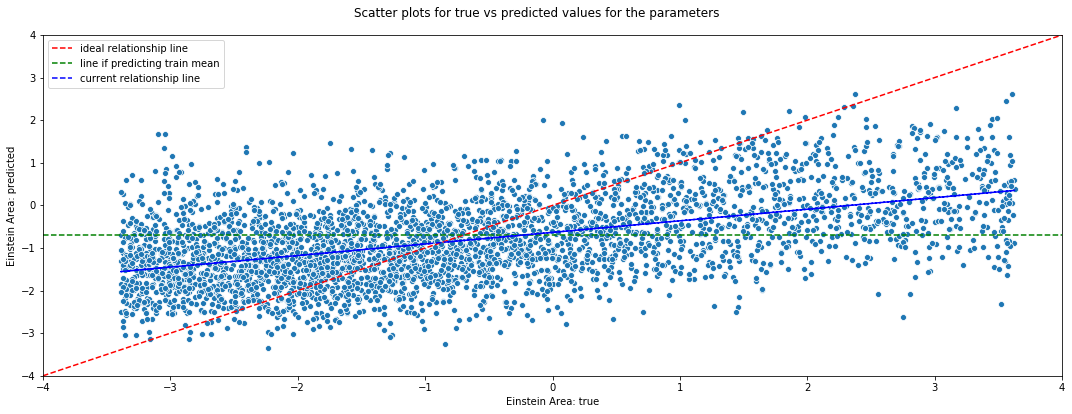

In [55]:
scatter_plots(epoch=8)

Get predictions for a single feature by running it multiple times through a  given model. Plot the resulting histogram, which will be an approximation of the predictive distribution.

In [0]:
def sample_predictive_epoch(feat, idx, n_iter=100000):
  batch_size = n_iter
  shape = feat.shape
  x = feat.view(-1, inputs, resize, resize)
  #x_nobias = remove_image_intensity_bias(x)
  feat_rep = x.repeat(batch_size, 1, 1, 1)
  if use_cuda:
        feat_rep = feat_rep.cuda()
  outs, kl, means, stds = nets[idx].probforward(feat_rep, ret_mean_std=True)
  outputs = outs.detach().cpu().numpy()
  #outputs = normalize(softplus(outs.detach().cpu().numpy()), axis=1, norm='l1')
  mn = means.detach().cpu().numpy()
  vn = (stds.detach().cpu().numpy() ** 2)
  confidence_mean = np.mean(outputs, axis=0)
  confidence_var = np.var(outputs, axis=0)
  epistemic = np.mean(mn ** 2, axis=0) - np.mean(mn, axis=0) ** 2 #np.mean(p_hat ** 2, axis=0) - np.mean(p_hat, axis=0) ** 2
  aleatoric = np.mean(vn, axis=0)
  
  return outputs, confidence_mean, confidence_var, epistemic, aleatoric
  

In [0]:
def plot_epochs(feat, label, epochs, n_iter=1000):
    n_epochs = len(epochs)
    #print(epochs)
    label = label.reshape(-1, outputs)
    meanY = np.array([train_mean]).reshape(-1, outputs)
    fig, ax = plt.subplots(nrows = n_epochs + 4, ncols = 2, figsize=(15, 5*n_epochs))
    means = np.zeros((outputs, n_epochs))
    vars = np.zeros((outputs, n_epochs))
    epistemics = np.zeros((outputs, n_epochs))
    aleatorics = np.zeros((outputs, n_epochs))
    bins = [np.linspace(-4, 4, 100)]
    xlims = [[-4.5, 4.5]]
    for i, epoch in enumerate(epochs):
        preds, m, v, ep, al = sample_predictive_epoch(feat, epoch, n_iter)
        means[:, i] = m
        vars[:, i] = v
        epistemics[:, i] = ep
        aleatorics[:, i] = al
        for j in range(outputs):
            lab = label[j][0]
            #print(lab)
            #print(preds.shape)
            sns.distplot(preds[:, j], ax=ax[i, j], kde=False, bins=bins[j], label='Epoch {}'.format(epoch))
            ax[i, j].plot([lab, lab], [0, 1000], 'r-', linewidth=2, label='Target = {:.4f}'.format(lab))
            ax[i, j].plot([meanY[j][0], meanY[j][0]], [0, 1000], 'g-', linewidth=2, label='Mean(trainY) = {:.4f}'.format(meanY[j][0]))
            ax[i, j].set_xlabel(output_names[j])
            ax[i, j].set_ylabel('hist count')
            ax[i, j].set_xlim(xlims[j])
            ax[i, j].set_xticks(np.arange(xlims[j][0], xlims[j][1], 0.75))
            ax[i, j].set_ylim(0, 100)
            ax[i, j].legend()
    
    estimates = [means, vars, epistemics, aleatorics]
    estimate_names = ['confidence_mean', 'confidence_var', 'epistemic uncertainty', 'aleatoric uncertainty']
    for i in range(n_epochs, n_epochs + 4):
        for j in range(outputs):
            idx = i - n_epochs
            sns.lineplot(x = epochs, y  = estimates[idx][j, :], ax=ax[i, j])
            ax[i, j].set_xlabel('#Epochs ({})'.format(output_names[j]))
            ax[i, j].set_ylabel(estimate_names[idx])
            ax[i, j].set_xticks(np.linspace(epochs[0], epochs[-1], 4))
    fig.suptitle('Sampled Predictive Distribution and estimates across Epochs.')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    
    print('\n\nParameter Estiamtes with Uncertainties:\n\n')
    epochs_str = [str(ep) for ep in epochs]
    for j in range(outputs):
        print('Parameter: {}'.format(output_names[j]))
        pp_estimates(epochs_str, means[j, :], vars[j, :], epistemics[j, :], aleatorics[j, :], tag='Epoch #' )

In [0]:
dataloader = iter(testloader)

In [0]:
features, labels = next(dataloader)

In [0]:
labels = labels.cpu().numpy()

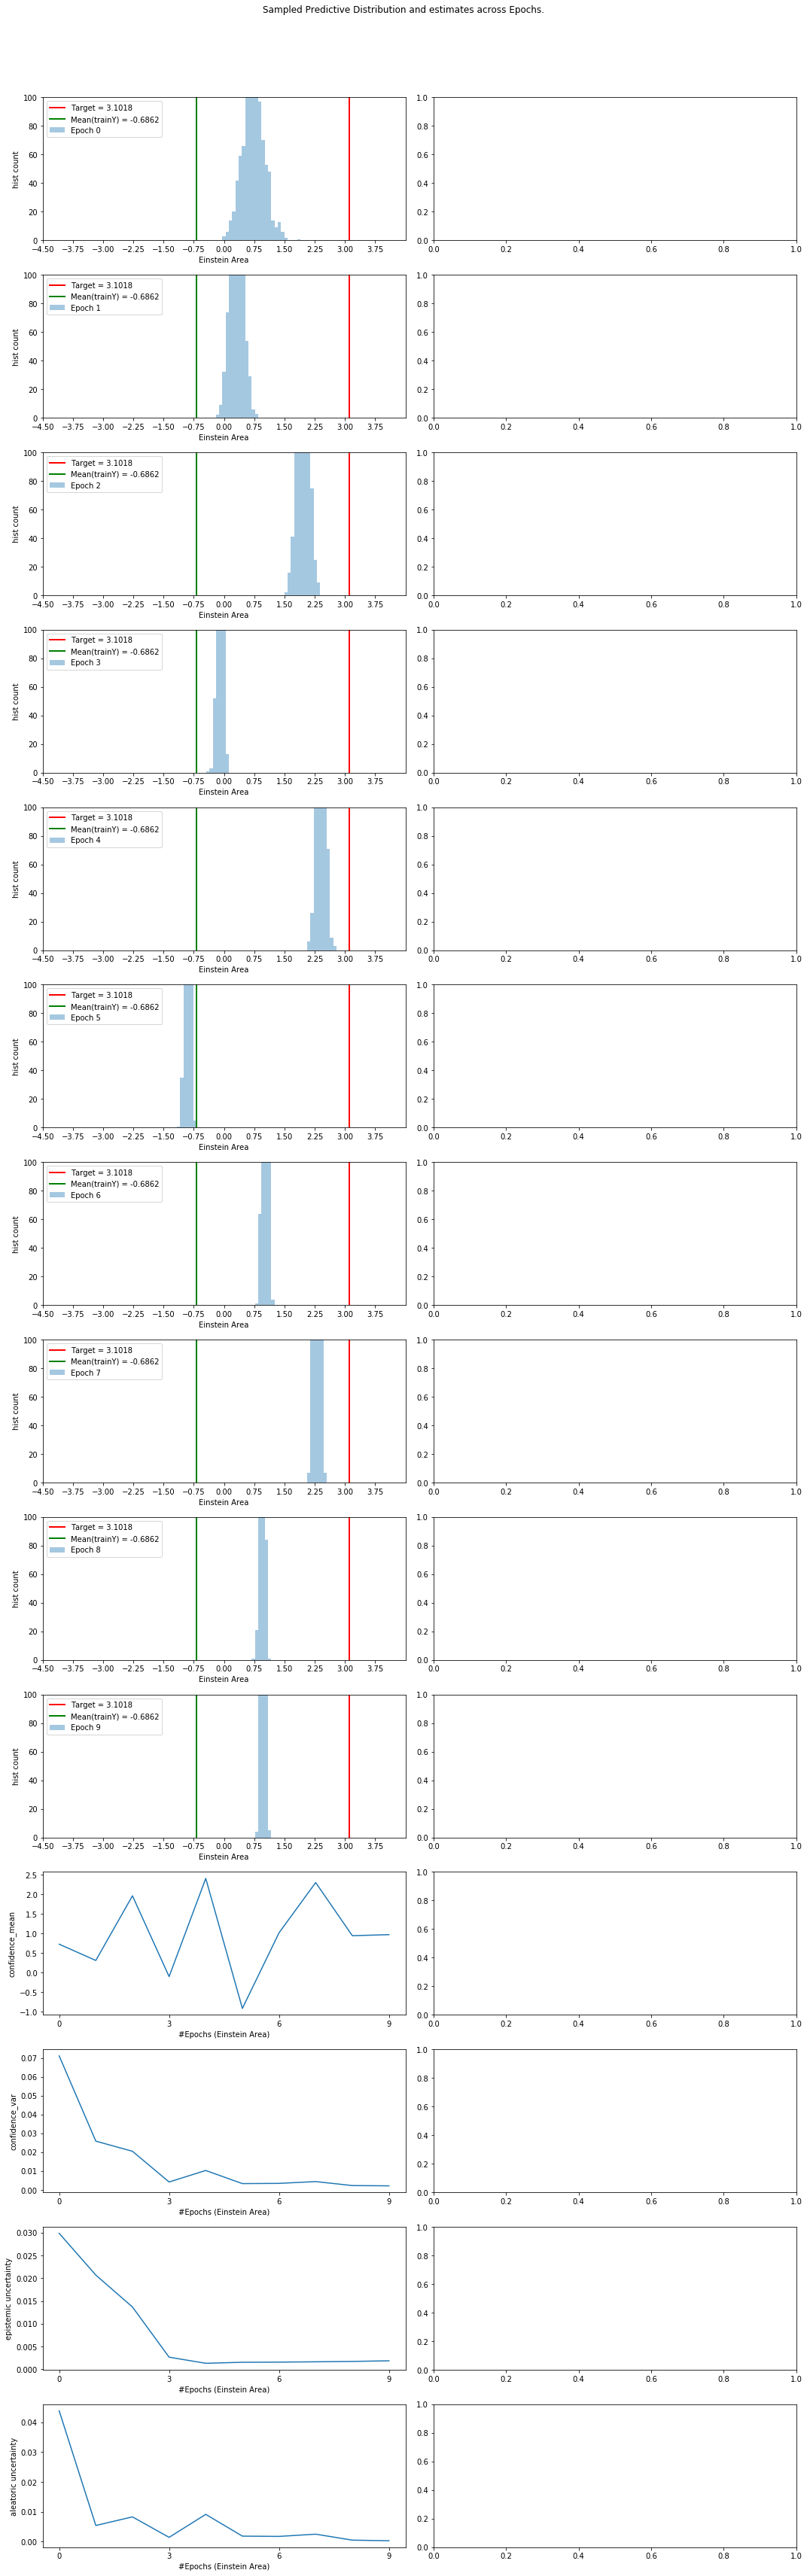



Parameter Estiamtes with Uncertainties:


Parameter: Einstein Area


----------------------------------------------------------------------------------------------

|        Epoch #| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|              0|           0.7276|    0.0711|                 0.0299|                 0.0438|

|              1|           0.3129|    0.0259|                 0.0207|                 0.0054|

|              2|           1.9619|    0.0205|                 0.0137|                 0.0083|

|              3|          -0.0993|    0.0042|                 0.0027|                 0.0014|

|              4|           2.4060|    0.0103|                 0.0013|                 0.0091|

|              5|          -0.9106|    0.0033|                 0.0016|                 0.0018|

|              6|           1.0179|    0.0035|                 0.

In [86]:
plot_epochs(features[5], labels[5], epochs, n_iter=1000)

In [0]:
plot_epochs(features[10], labels[10].numpy(), epochs[::5], n_iter=1000)

In [0]:
plot_epochs(features[25], labels[25].numpy(), epochs[::5], n_iter=1000)